In [1]:
##################################
### Import the usual libraries ###
##################################

#numpy
import numpy as np

# scipy
# from scipy.stats import binned_statistic

#astropy
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column, QTable

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

# Yumi's Code to convert (RA,DEC) to MS coordinates
# import MagellanicStream as ms

# .py files for grad calc
# import astrofunctions as astro
# import lmcgeometry as lgeo
# import mlefitting as mle
# import utilities as util

# import mcmc as mc

import emcee

# Ignore warnings unless crashes
import warnings
warnings.filterwarnings('ignore')

#progress bars
from tqdm import tqdm_notebook

In [40]:
######################
### MCMC Fucntions ###
######################

import numpy as np
from scipy.optimize import minimize
from scipy.stats import binned_statistic

### MLE Functions

def mad(dat):
    '''
    Calculate the median absolute deviation (MAD)
    
    Parameters:
    -----
        dat: array-like object containing data
    
    Returns:
    ----
        dev: MAD(dat)
    '''
    dev = np.median(np.absolute(dat - np.median(dat)))
    return dev

def agemodl(b,x):
    '''
    General model for ages upto 3rd order in logTe, Ksmag, MH, logg with simple interactions of linear terms. 
    
    Parameters:
    -----
        b: array-like object of model parameters with length 19
        x: array of independent variables (logTe, Ksmag, MH, logg)
    
    Returns:
    ----
        y: age
    '''
#     y = (b[0]+
#          b[1]*x[0]+b[2]*x[1]+b[3]*x[2]+b[4]*x[3]+
#          b[9]*np.square(x[0])+b[10]*np.square(x[2])+b[11]*np.square(x[3])+
#          b[12]*np.power(x[0],3)+b[13]*np.power(x[3],3))

    y = (b[0]+
         b[1]*x[0]+b[2]*x[1]+b[3]*x[2]+b[4]*x[3]+ 
         b[5]*np.multiply(x[0],x[1])+b[6]*np.multiply(x[0],x[2])+b[7]*np.multiply(x[0],x[3])+
         b[8]*np.multiply(x[1],x[2])+b[9]*np.multiply(x[1],x[3])+
         b[10]*np.multiply(x[2],x[3])+
         b[11]*np.square(x[0])+b[12]*np.square(x[1])+b[13]*np.square(x[2])+b[14]*np.square(x[3])+
         b[15]*np.power(x[0],3)+b[16]*np.power(x[1],3)+b[17]*np.power(x[2],3)+b[18]*np.power(x[3],3))

#     y = (b[0]+
#          b[1]*x[0]+b[2]*x[1]+b[3]*x[2]+b[4]*x[3]+
#          b[5]*np.square(x[0])+b[6]*np.square(x[1])+b[7]*np.square(x[2])+b[8]*np.square(x[3])+
#          b[9]*np.power(x[0],3)+b[10]*np.power(x[1],3)+b[11]*np.power(x[2],3)+b[12]*np.power(x[3],3))
    
    return y

def agemodl_x0(b,x):
    '''
    Derivative of agemodl wrt x0 (logTe)
    '''
    return b[1]+2*b[9]*x[0]+3*b[12]*np.square(x[0])
    #b[1]+2*b[11]*x[0]+3*b[15]*np.square(x[0])+b[5]*x[1]+b[6]*x[2]+b[7]*x[3]
    #b[1]+2*b[5]*x[0]+3*b[9]*np.square(x[0])

def agemodl_x1(b,x):
    '''
    Derivative of agemodl wrt x1 (Ksmag)
    '''
    return b[2]
    #b[2]+b[5]*x[0]+2*b[12]*x[1]+3*b[16]*np.square(x[1])+b[8]*x[2]+b[9]*x[3]
    #b[2]+2*b[6]*x[0]+3*b[10]*np.square(x[1])

def agemodl_x2(b,x):
    '''
    Derivative of agemodl wrt x2 ([Fe/H])
    '''
    return b[3]+2*b[10]*x[2]
    #b[3]+b[6]*x[0]+b[8]*x[1]+2*b[13]*x[2]+3*b[17]*np.square(x[2])+b[10]*x[3]
    #b[3]+2*b[7]*x[0]+3*b[11]*np.square(x[2])

def agemodl_x3(b,x):
    '''
    Derivative of agemodl wrt x3 (logg)
    '''
    return b[4]+2*b[11]*x[3]+3*b[13]*np.square(x[3])
    #b[4]+b[7]*x[0]+b[9]*x[1]+b[10]*x[2]+2*b[14]*x[3]+3*b[18]*np.square(x[3])
    #b[4]+2*b[8]*x[0]+3*b[12]*np.square(x[3])

def lnL(theta,x,y):
    '''
    Log likelihood for agemodl
    
    Parameters:
    -----
        theta: parameters to plug into linmodl (m,b)
        x: exog of line
        y: endog of line
        cv: covariance matrix of x data
    
    Returns:
    ----
        lnl: log likelihood 
    '''
  
    b = theta
    cv = np.cov(x)
    modl = agemodl(b,x)
    derivx0 = agemodl_x0(b,x)
    derivx1 = agemodl_x1(b,x)
    derivx2 = agemodl_x2(b,x)
    derivx3 = agemodl_x3(b,x)
    inv_sig2 = 1.#np.reciprocal(derivx0**2*cv[0,0]+derivx1**2*cv[1,1]+derivx2**2*cv[2,2]+derivx3**2*cv[3,3]+
#                              2.*np.abs(derivx0*derivx1)*cv[0,1]+2.*np.abs(derivx0*derivx2)*cv[0,2]+
#                              2.*np.abs(derivx0*derivx3)*cv[0,3]+
#                              2.*np.abs(derivx1*derivx2)*cv[1,2]+2.*np.abs(derivx1*derivx3)*cv[1,3]+
#                              2.*np.abs(derivx2*derivx3)*cv[2,3])
#     np.reciprocal(derivx0**2*cv[0,0]+derivx1**2*cv[1,1]+derivx2**2*cv[2,2]+derivx3**2*cv[3,3]+2*derivx0*derivx1*cv[0,1]+2*derivx0*derivx2*cv[0,2]+2*derivx0*derivx3*cv[0,3]+2*derivx1*derivx2*cv[1,2]+2*derivx1*derivx3*cv[1,3]+2*derivx2*derivx3*cv[2,3])
    lnl = -0.5 * np.sum(np.multiply(np.square((y - modl)),inv_sig2) - np.log(inv_sig2/(2*np.pi)))
    return lnl

### MCMC Specific

def lnPrior(theta):
    '''
    Using a flat prior to calculate the log prior
    
    Parameters:
    -----
    theta: model parameters
    
    '''
    b = theta
    if (-1000. < b[0] < 1000. and -50. < b[1] < 50. and -50. < b[2] < 50. and -50. < b[3] < 50. and 
        -50. < b[4] < 50. and -50. < b[5] < 50. and -50. < b[6] < 50. and -50. < b[7] < 50. and 
        -50. < b[8] < 50. and -50. < b[9] < 50. and -50. < b[10] < 50. and -50. < b[11] < 50. and 
        -50. < b[12] < 50. and -50. < b[13] < 50. and -50. < b[14] < 50. and -50. < b[15] < 50. and
        -50. < b[16] < 50. and -50. < b[17] < 50. and -50. < b[18] < 50.):
        return 0.0
    return -np.inf

def lnProb(theta, x, y):
    '''
    Calculate the log probability
    
    Parameters:
    -----
    theta: model parameters
    x: x coordinate data
    y: y coordinate data
    y_err: y error
    
    '''
    
    lnP = lnPrior(theta)
    if not np.isfinite(lnP):
        return -np.inf
    return lnP + lnL(theta, x, y)

In [3]:
# PARSEC Isochrones
parsec = ascii.read('/Users/joshpovick/Research/MCMC_Ages/parsec3_3.dat',format='basic', delimiter='\s')

rgb = np.where(parsec['label']==3)
parsec = parsec[rgb]

# LMC r13 data
lmc = fits.getdata('/Users/joshpovick/Research/LMC_Gradients_with_Ages/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-9999.0)&(lmc['LOGG']>0.0)&
                (lmc['M_H_ERR']>-90.0)&(lmc['C_FE']>-9999.0)&(lmc['N_FE']>-9999.0))

lmc = lmc[cln]

# Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/LMC_DR16_all_PDF.fits.gz', 1)
_, lmc_ind, pdfout_ind = np.intersect1d(lmc['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

In [33]:
dat = np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']])

In [41]:
### MCMC

#length of guess muct be the same as ndim

guess = np.ones(19)
niter = 1000
ndim, nwalkers = 19,500 
pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnProb, args=(dat, parsec['logAge']))
sampler.run_mcmc(pos, 5000, progress=True)

tau = sampler.get_autocorr_time()
print(tau)   



  0%|          | 1/5000 [00:01<2:12:58,  1.60s/it]Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-40-0ade7d9dad58>", line 159, in lnProb
    return lnP + lnL(theta, x, y)
  File "<ipython-input-40-0ade7d9dad58>", line 109, in lnL
    modl = agemodl(b,x)
  File "<ipython-input-40-0ade7d9dad58>", line 50, in agemodl
    b[15]*np.power(x[0],3)+b[16]*np.power(x[1],3)+b[17]*np.power(x[2],3)+b[18]*np.power(x[3],3))
KeyboardInterrupt
  0%|          | 1/5000 [00:03<4:55:48,  3.55s/it]

emcee: Exception while calling your likelihood function:
  params: [0.99961844 1.00070691 1.00004186 1.0015322  1.00047594 0.99993509
 0.99880362 0.99994954 1.00067171 1.00015894 0.9991221  0.99960352
 1.00143312 1.00014438 1.00005854 1.00026406 1.00061702 1.00083387
 0.9997139 ]
  args: (array([[ 3.71660e+00,  3.71250e+00,  3.71180e+00, ...,  3.49410e+00,
         3.48980e+00,  3.48490e+00],
       [-4.80700e+00, -4.87800e+00, -4.89400e+00, ..., -6.84700e+00,
        -6.95100e+00, -7.06800e+00],
       [-2.19174e+00, -2.19174e+00, -2.19174e+00, ...,  7.30000e-02,
         7.30000e-02,  7.30000e-02],
       [ 1.74000e+00,  1.70700e+00,  1.69900e+00, ...,  1.00000e-03,
        -5.00000e-02, -1.10000e-01]]), <Column name='logAge' dtype='float64' length=14946>
  8.1
  8.1
  8.1
  8.1
  8.1
  8.1
  8.1
  8.1
 8.25
 8.25
 8.25
 8.25
  ...
10.05
10.05
10.05
10.05
10.05
10.05
10.05
10.05
10.05
10.05
10.05
10.05)
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [6]:
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True) 

beta 0: -48.13525 +/- 3.36006
beta 1: 46.57481 +/- 2.41501
beta 2: -0.75344 +/- 0.05825
beta 3: 0.11649 +/- 0.01773
beta 4: 1.91212 +/- 0.13376
beta 5: -0.46696 +/- 0.01570
beta 6: -0.01167 +/- 0.00479
beta 7: 1.12009 +/- 0.03782
beta 8: -0.00503 +/- 0.00019
beta 9: 0.79966 +/- 0.00405
beta 10: 0.01258 +/- 0.00050
beta 11: -13.56000 +/- 0.70384
beta 12: -0.16224 +/- 0.00081
beta 13: 0.05726 +/- 0.00158
beta 14: -0.96521 +/- 0.00506
beta 15: 1.21908 +/- 0.06927
beta 16: 0.00014 +/- 0.00000
beta 17: 0.00966 +/- 0.00028
beta 18: -0.00198 +/- 0.00006
[4.81352481e+01 4.65748051e+01 7.53435306e-01 1.16492175e-01
 1.91212499e+00 4.66960979e-01 1.16723726e-02 1.12009366e+00
 5.03314622e-03 7.99661214e-01 1.25813748e-02 1.35599984e+01
 1.62239234e-01 5.72613062e-02 9.65213254e-01 1.21907682e+00
 1.40556366e-04 9.66478685e-03 1.98220628e-03]


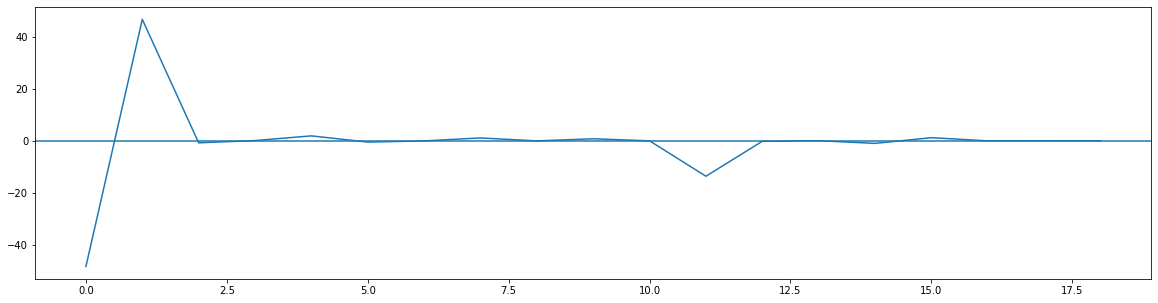

In [8]:
betas = []
betas_err = []
for i in range(len(guess)):
    betas.append(np.median(flat_samples[:,i]))
    betas_err.append(mad(flat_samples[:,i]))
    
betas
betas_err

for j in range(len(betas)):
    print(r'beta {}: {:.5f} +/- {:.5f}'.format(j,betas[j],betas_err[j]))
    
plt.figure(figsize=[20,5])
plt.plot(betas)
plt.axhline(0)
print(np.abs(betas))

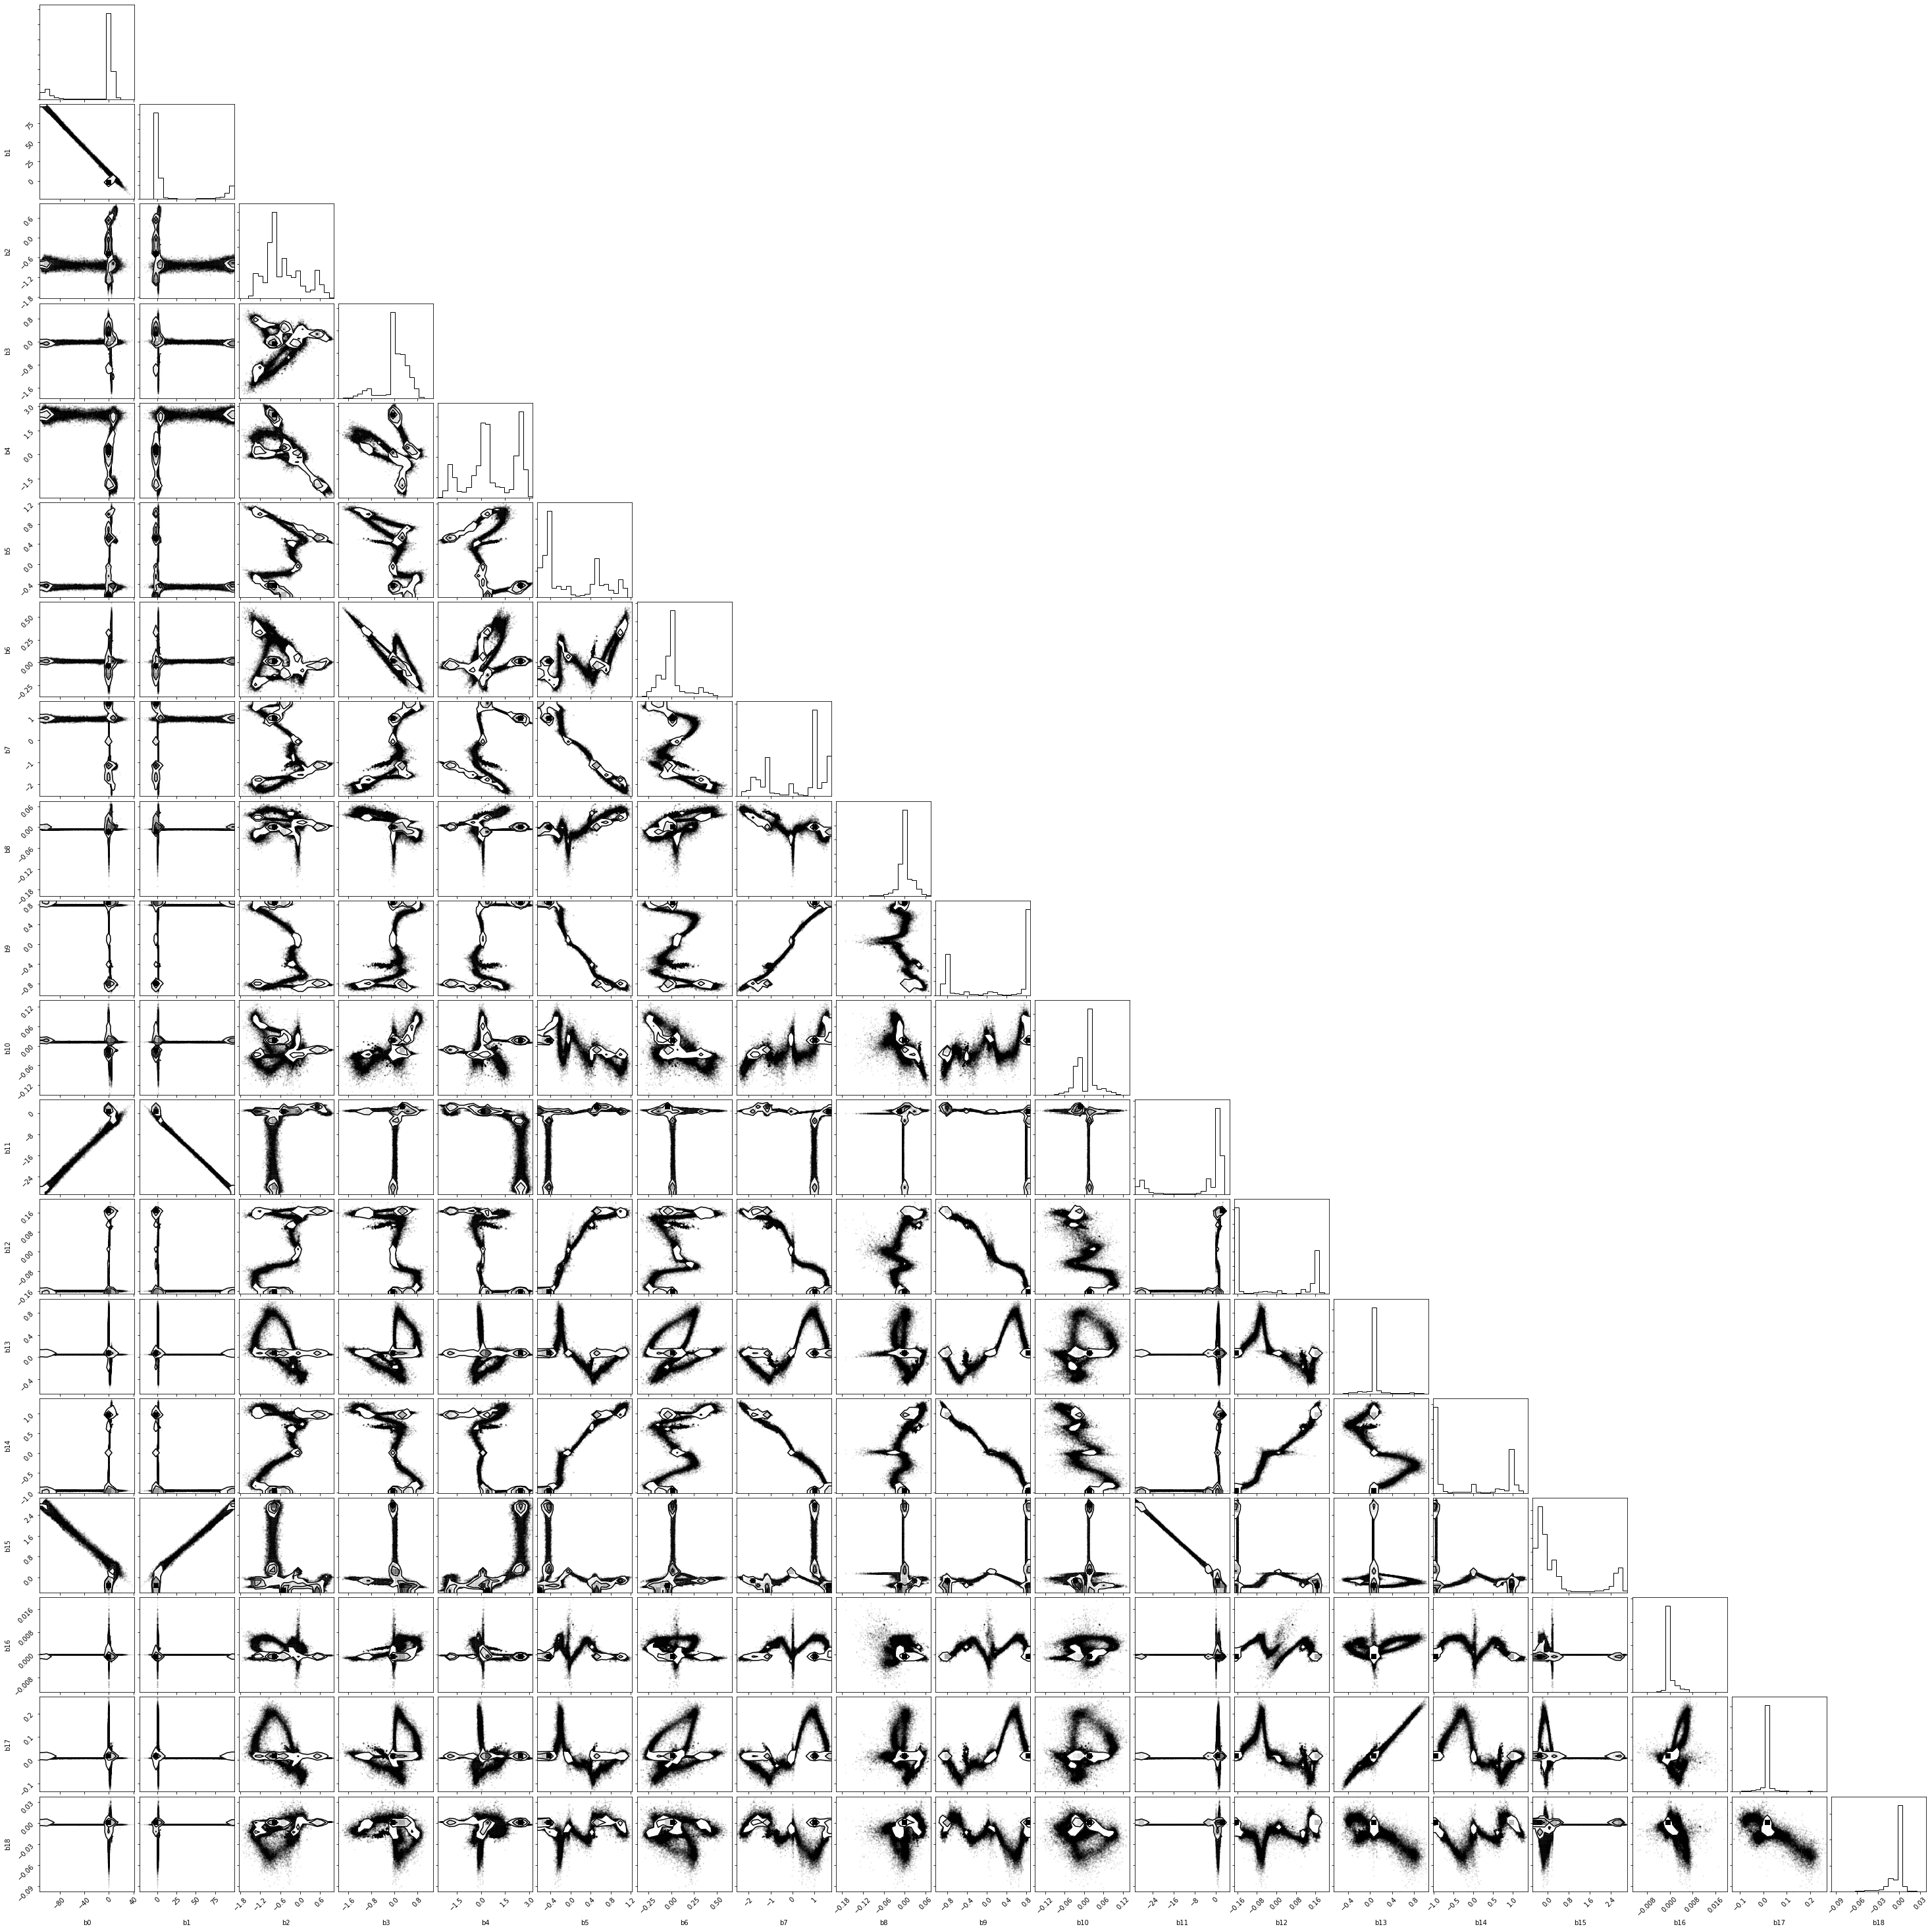

In [18]:
import corner

fig = corner.corner(flat_samples,
                    labels=['b0','b1','b2','b3','b4','b5','b6','b7','b8','b9','b10','b11','b12','b13','b14','b15',
                            'b16','b17','b18']);

In [20]:
def find_age(b,x0,x1,x2,x3):
    '''
    General model for ages upto 3rd order in logTe, Ksmag, MH, logg with simple interactions of linear terms. 
    
    Parameters:
    ----------
        b: array-like object of model parameters with length 19
        x0: temperature
        x1: magnitude
        x2: metallicity
        x3: logg
    
    Returns:
    -------
        y: age
    '''
    y = (b[0]+
         b[1]*x0+b[2]*x1+b[3]*x2+b[4]*x3+
         b[9]*np.square(x0)+b[10]*np.square(x2)+b[11]*np.square(x3)+
         b[12]*np.power(x0,3)+b[13]*np.power(x3,3))
    
#     y = (b[0]+
#          b[1]*x0+b[2]*x1+b[3]*x2+b[4]*x3+
#          b[5]*np.square(x0)+b[6]*np.square(x1)+b[7]*np.square(x2)+b[8]*np.square(x3)+
#          b[9]*np.power(x0,3)+b[10]*np.power(x1,3)+b[11]*np.power(x2,3)+b[12]*np.power(x3,3))
    
#     y = (b[0]+
#          b[1]*x0+b[2]*x1+b[3]*x2+b[4]*x3+ 
#          b[5]*np.multiply(x0,x1)+b[6]*np.multiply(x0,x2)+b[7]*np.multiply(x0,x3)+
#          b[8]*np.multiply(x1,x2)+b[9]*np.multiply(x1,x3)+
#          b[10]*np.multiply(x2,x3)+
#          b[11]*np.square(x0)+b[12]*np.square(x1)+b[13]*np.square(x2)+b[14]*np.square(x3)+
#          b[15]*np.power(x0,3)+b[16]*np.power(x1,3)+b[17]*np.power(x2,3)+b[18]*np.power(x3,3))
    

#     (b[0]+
#          b[1]*x0+b[2]*x1+b[3]*x2+b[4]*x3+
#          b[5]*np.multiply(x0,x2)+b[6]*np.multiply(x0,x3)+
#          b[7]*np.multiply(x1,x3)+
#          b[8]*np.multiply(x2,x3)+
#          b[9]*np.square(x0)+b[10]*np.square(x1)+b[11]*np.square(x2)+b[12]*np.square(x3)+
#          b[13]*np.power(x0,3)) 
    
    return y

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

#calculate absolute mag
def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

def salaris(MH,aM):
    '''
    Calculate the Salaris correction to the overall metallicity
    '''
    return MH + np.log(0.638*(10**(aM))+0.362)
    
    
def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

In [11]:
age_dist = []

for i in tqdm_notebook(range(len(lmc)),desc='Done?'):
    # temperature
    teff = lmc['TEFF'][i]
    teff_err = lmc['TEFF_ERR'][i]
    
    # photometry 
    ra = lmc['RA'][i]
    dec = lmc['DEC'][i]
    
    ks = lmc['K'][i]
    ks_err = lmc['K_ERR'][i]
    ak = lmc['AK_TARG'][i]
    
    # abundances
    mh = lmc['M_H'][i]
    mh_err = lmc['M_H_ERR'][i]
    aM = lmc['ALPHA_M'][i]
    aM_err = lmc['ALPHA_M_ERR'][i]
#     feh = lmc['FE_H'][i]
#     feh_err = lmc['FE_H_ERR'][i]
    
    # surface gravity
    lgg = lmc['LOGG'][i]
    lgg_err = lmc['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
#         x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
#                                  add_noise(feh,feh_err)-add_noise(mh,mh_err))
#         x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
#                                  add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
#         ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        aM_new = add_noise(aM,aM_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
#         new = np.array([lgteff_new,absK_new,salaris(mh_new,aM_new),lgg_new])
        noise_ages.append(find_age(betas,lgteff_new,absK_new,salaris(mh_new,aM_new),lgg_new))
        
#         new.append(np.array([lgteff_new,absK_new,salaris(mh_new,aM_new),lgg_new]))
        
#     zs = pca_transform.transform(np.asarray(np.squeeze(new)))

#     for l in range(len(zs)):
#         noise_ages.append(find_ages(new[l][0],new[l][1],new[l][2]))
    
    age_dist.append(noise_ages)

ages = [] 
ages_err = []
for k in tqdm_notebook(range(len(age_dist))):
    ages_err.append(mad(age_dist[k]))
    ages.append(np.median(age_dist[k]))

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 8.000e+00, 4.600e+01, 2.531e+03]),
 array([4.1281269 , 4.68681835, 5.2455098 , 5.80420125, 6.36289271,
        6.92158416, 7.48027561, 8.03896706, 8.59765851, 9.15634996,
        9.71504141]),
 <a list of 10 Patch objects>)

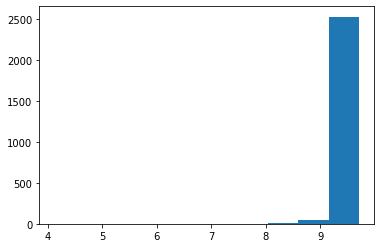

In [12]:
plt.hist(np.asarray(ages))

(array([1.76e+03, 6.20e+02, 1.38e+02, 5.20e+01, 7.00e+00, 7.00e+00,
        1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00]),
 array([0.00192174, 0.02021613, 0.03851052, 0.0568049 , 0.07509929,
        0.09339368, 0.11168806, 0.12998245, 0.14827684, 0.16657122,
        0.18486561]),
 <a list of 10 Patch objects>)

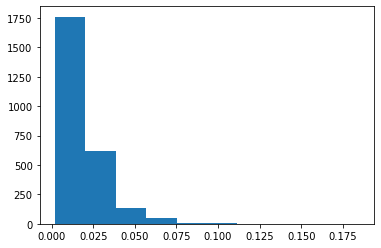

In [13]:
plt.hist(np.asarray(ages_err))

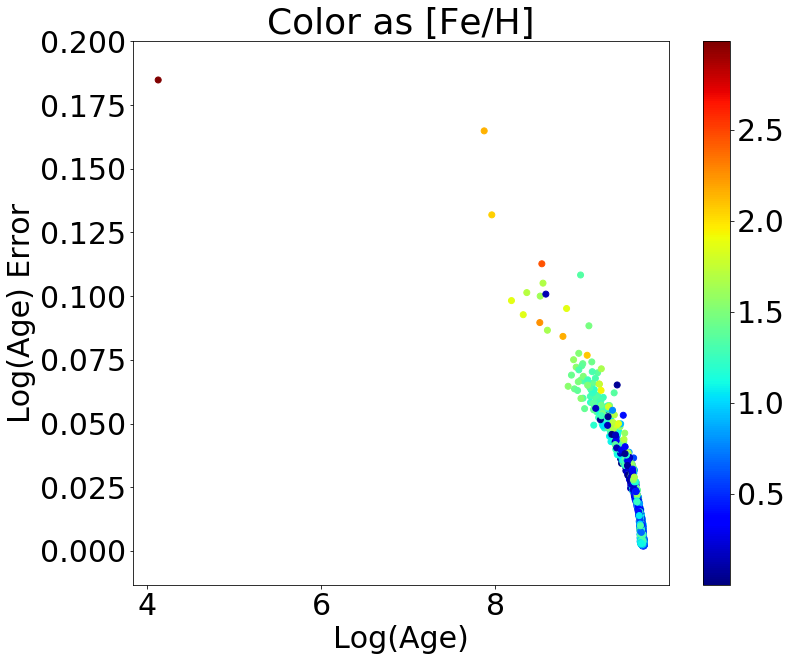

In [14]:
matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=[12,10])
plt.scatter(ages,ages_err,c=lmc['LOGG'],cmap='jet')
plt.colorbar()

# plt.ylim(0,0.25)
# plt.xlim(7.5,12.35)

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Log(Age)')
plt.ylabel(r'Log(Age) Error')

# plt.savefig('age_err.pdf',bbox_inches='tight')
plt.show()

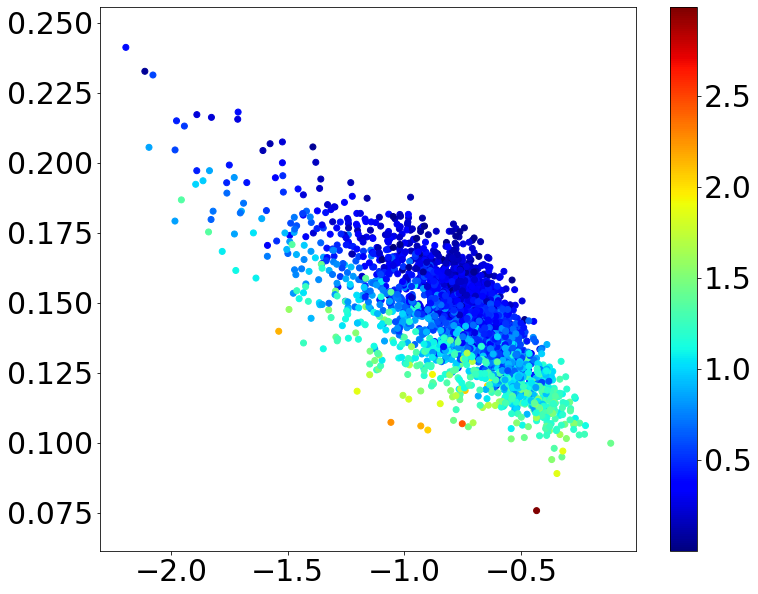

In [20]:
matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=[12,10])
plt.scatter(lmc['FE_H'],ages_err,c=lmc['LOGG'],cmap='jet')
plt.colorbar()

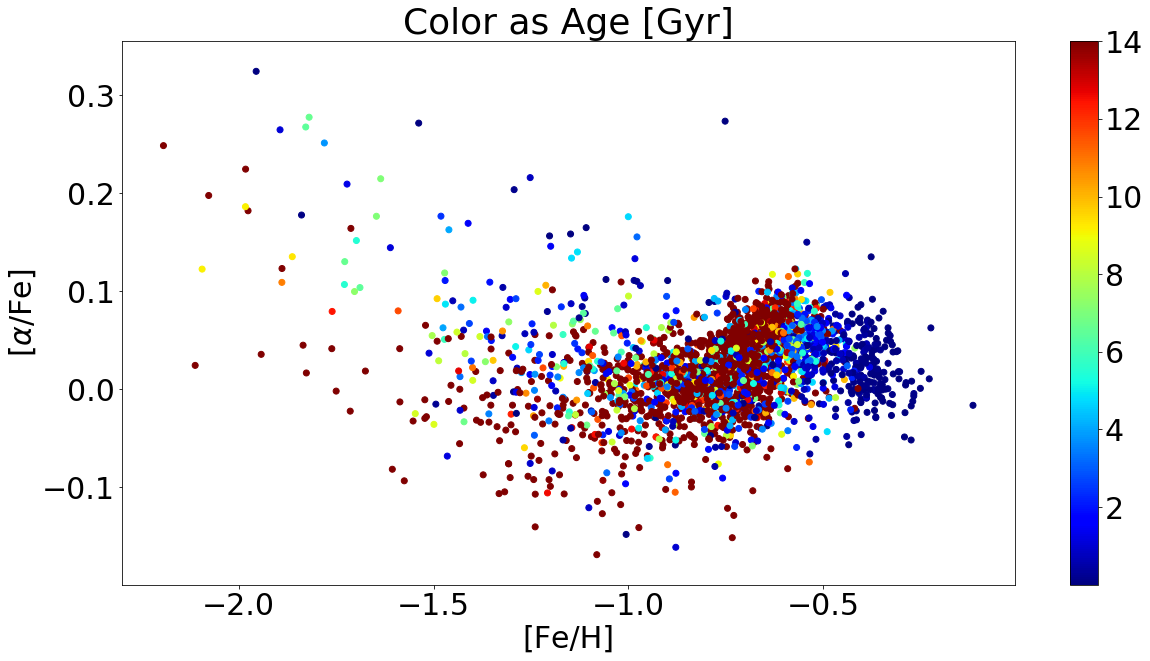

In [22]:
plt.figure(figsize=[20,10])
plt.scatter(lmc['FE_H'],lmc['ALPHA_M']+lmc['M_H']-lmc['FE_H'],
            c=10**np.asarray(ages)/10**9,cmap='jet',
            vmax=14.0)
plt.colorbar()

plt.title(r'Color as Age [Gyr]')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')

# plt.savefig('alphaFe_AGES.pdf',bbox_inches='tight')
plt.show()

In [48]:
### Error propagation with parameters and errors derive

(10000000, 1000000000000)

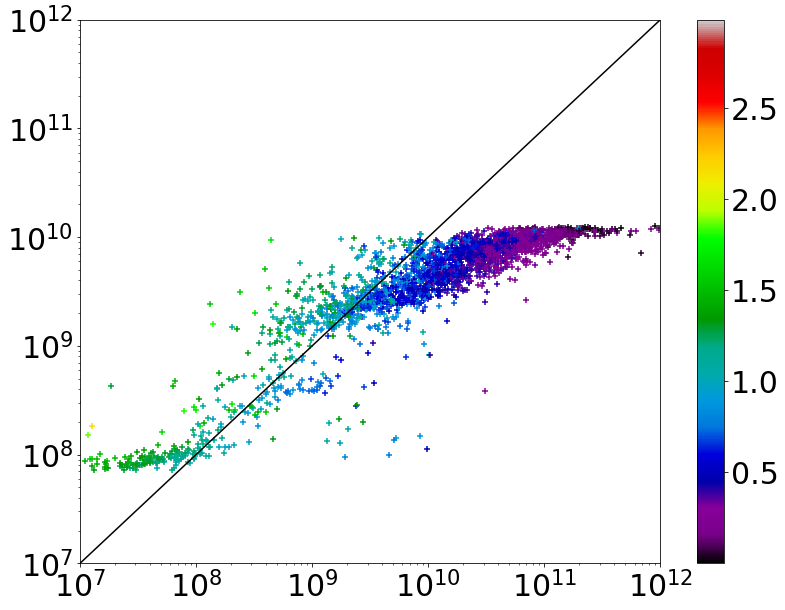

In [23]:
plt.figure(figsize=[13,10])
plt.scatter(10**np.asarray(ages)[lmc_ind],10**pdfout['P_MEAN'][pdfout_ind],c=lmc['LOGG'][lmc_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**12)
plt.xlim(10**7,10**12)

In [ ]:
4*cv[0,0]